In [ ]:
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import ace_tools_open as tools; 
import spacy
from spacy.lang.pt.examples import sentences 
from string import punctuation
import matplotlib.pyplot as plt
from transformers import pipeline
import tensorflow as tf
from bs4 import BeautifulSoup
import requests
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Counter

In [4]:
nlp = spacy.load('pt_core_news_sm') # commented out once it's loaded

punctuations = list(punctuation)

In [5]:
# Newspapers to search

newsp = ['cmjornal.pt/', 
         'dn.pt/',
         'expresso.pt/',
         'folhanacional.pt/',
         'jn.pt/',
         'ionline.sapo.pt/',   
         'sol.sapo.pt/',
         'observador.pt/',
         'publico.pt/',
         'sabado.pt/',
         'sapo.pt/',
         'visao.pt/',
         ]

not_keywords = ["/multimedia", "/videos", 
                "/famosos", "/celebridades", 
                "/tecnologia", "/boa-vida", 
                "/tendencias", "/desporto",
                "/maissobre", "/ciencia",
                "/cinema", "/cultura",
                "/cidades", "/dinheiro",
                "/blogues", "/podcasts",
                "/vida", "/artes",
                "/iniciativas", "/colunistas/andre",
                "/tribuna"]

stop_words = {'comprida', 'lá', 'mesmo', 'ela', 'de', 'quero', 'vão', 'nesta', 'em', 'com',
              'tais', 'neste', 'obrigado', 'bom', 'for', 'vai', 'fazer', 'tens', 'alguns', 'todos',
              'tu', 'muito', 'estás', 'deve', 'novas', 'todo', 'foste', 'pode', 'pontos', 'pegar',
              'quieto', 'seria', 'eles', 'coisa', 'faz', 'sou', 'daquela', 'tua', 'suas', 'teu',
              'cuja', 'esses', 'vindo', 'aquele', 'um', 'certamente', 'essa', 'no', 'vens', 'também',
              'maiorias', 'fostes', 'tanta', 'elas', 'desse', 'diante', 'pelas', 'nove', 'quinta', 'maior',
              'do', 'quando', 'aqueles', 'desta', 'sabe', 'ambas', 'que', 'tentar', 'estes', 'próximo',
              'povo', 'sem', 'uns', 'tão', 'além', 'geral', 'porquanto', 'fora', 'vêm', 'tivemos',
              'depois', 'ir', 'ora', 'tarde', 'nessa', 'da', 'nós', 'ver', 'tiveram', 'tem',
              'cada', 'exemplo', 'número', 'meus', 'tuas', 'conhecido', 'cento', 'devem', 'para', 'fomos',
              'à', 'favor', 'quanto', 'teve', 'apenas', 'este', 'vais', 'mas', 'querem', 'lugar',
              'vinte', 'quê', 'após', 'apoio', 'mal', 'quarta', 'grande', 'adeus', 'pelos', 'parece',
              'dezanove', 'ligado', 'sob', 'estou', 'ao', 'final', 'talvez', 'demais', 'aos', 'agora',
              'você', 'nem', 'maioria', 'vez', 'treze', 'menor', 'temos', 'possível', 'ambos', 'não',
              'isto', 'dezoito', 'tempo', 'estas', 'área', 'nenhuma', 'fui', 'estará', 'cujo', 'faço',
              'bem', 'logo', 'quais', 'onde', 'menos', 'aquela', 'quatro', 'outras', 'pouca', 'dar',
              'dezasseis', 'último', 'valor', 'é', 'antes', 'aqui', 'mais', 'sétimo', 'dizem', 'estão',
              'veja', 'dezassete', 'ele', 'tivestes', 'tive', 'quarto', 'nova', 'bastante', 'pois', 'apoia',
              'outra', 'teus', 'caminho', 'fazeis', 'lado', 'somente', 'esteve', 'fazemos', 'nesse', 'dessa',
              'numa', 'qualquer', 'momento', 'assim', 'esse', 'boa', 'pôde', 'duas', 'longe', 'meio',
              'saber', 'és', 'ponto', 'daquele', 'estava', 'irá', 'perto', 'num', 'aí', 'umas',
              'nossas', 'falta', 'o', 'dão', 'quer', 'custa', 'tipo', 'sexto', 'vinda', 'segundo',
              'sétima', 'ter', 'seu', 'poder', 'enquanto', 'algo', 'sois', 'se', 'poderá', 'grandes',
              'naquele', 'dá', 'novos', 'tanto', 'cedo', 'vossas', 'cima', 'posição', 'era', 'na',
              'ser', 'vossos', 'seis', 'terceira', 'fim', 'onze', 'disso', 'tentei', 'iniciar', 'minha',
              'apontar', 'estiveram', 'quem', 'fará', 'até', 'sexta', 'zero', 'pouco', 'então', 'sei',
              'vossa', 'ainda', 'nuns', 'parte', 'sua', 'a', 'mês', 'acerca', 'terceiro', 'primeiro',
              'estar', 'oitava', 'grupo', 'porquê', 'contra', 'me', 'forma', 'dizer', 'sete', 'toda',
              'dois', 'portanto', 'estado', 'podia', 'vos', 'máximo', 'vocês', 'comprido', 'tenho', 'baixo',
              'somos', 'através', 'são', 'quinto', 'nada', 'segunda', 'outros', 'sempre', 'vosso', 'certeza',
              'debaixo', 'oitavo', 'lhe', 'dos', 'mil', 'têm', 'desde', 'nível', 'nos', 'usar',
              'primeira', 'fazes', 'fazia', 'tiveste', 'deste', 'corrente', 'oito', 'vós', 'doze', 'das',
              'sistema', 'inclusive', 'já', 'vem', 'contudo', 'minhas', 'cinco', 'estivestes', 'naquela', 'nas',
              'vários', 'tal', 'fazem', 'tentaram', 'posso', 'estiveste', 'direita', 'isso', 'embora', 'pela',
              'uma', 'breve', 'nossa', 'números', 'nossos', 'essas', 'dentro', 'deverá', 'partir', 'próxima',
              'eventual', 'conselho', 'às', 'esta', 'foi', 'só', 'te', 'possivelmente', 'obrigada', 'relação',
              'meses', 'três', 'põem', 'quieta', 'fez', 'ali', 'aquilo', 'sobre', 'qual', 'atrás',
              'estive', 'está', 'sim', 'estivemos', 'todas', 'cá', 'ou', 'muitos', 'porque', 'foram',
              'algumas', 'pelo', 'por', 'tente', 'questão', 'nosso', 'local', 'novo', 'nunca', 'como',
              'meu', 'tudo', 'porém', 'as', 'vezes', 'usa', 'os', 'diz', 'e', 'dez',
              'ademais', 'seus', 'conhecida', 'ontem', 'quinze', 'põe', 'des', 'entre', 'eu', 'catorze',
              'próprio', 'tendes', 'aquelas', 'podem', 'inicio', 'puderam', 'de o', 'correio', ' ', 'manhã',
              'a o', 'comentário', 'conteúdo', 'espaço', 'leitor', '', '”','“', 'em o', 'em a', 'em os', 'em as', 'em',
              'em de', 'em da', 'em do', 'em dos', 'em para', 'em por', 'em com', 'em sem', 'em sobre', 'em sob', 'em acerca',
              'em um', 'em uma', 'em uns', 'em umas', 'em ao', 'em à', 'em aos', 'em às', 'em na', 'em no', 'em nas', 'em nos',
              ' ', '  ', '...'}

In [4]:
df = pd.read_csv('working_file_061224.csv')

# Drop the columns authors, published_date, unnamed: 0, lemmas, Lemma_string, year, lemmas_filtered
df = df.drop(columns=['authors', 'publish_date', 'Unnamed: 0', 'Lemmas', 'Lemma_String', 'year', 'Lemmas_filtered', 'text'])
# Display df using ace tools
tools.display_dataframe_to_user(name="Frequency of Text Length Bins", dataframe=df)
# Count not NaN values in column text
df['filtered_text'].count()


Frequency of Text Length Bins


698

In [10]:
lemmas_dict = {}

# Loop through each text along with its index
for index, row in df.iterrows():
    text = row['filtered_text']  # Access the 'text' column
    if text is None or not isinstance(text, str):
        print(f"Skipping index {index} because the text is None")
        continue
    doc = nlp(text)
    lemmas = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    lemmas = [ word for word in lemmas if word not in stop_words and word not in punctuations ]
    lemmas = [word for word in lemmas if word not in {"em o", "por o", "", "“", "”", "de este", "em este"}]  # Additional filter
    lemmas_dict[index] = lemmas  # Store lemmas in the dictionary with index as key

# Convert dictionary to a series and assign as a new column in the DataFrame
df['Lemmas_filtered'] = pd.Series(lemmas_dict)

df['Lemmas_str'] = df['Lemmas_filtered'].apply(lambda x: ' '.join(x))

In [6]:
df = pd.read_csv('working_file_081224.csv')

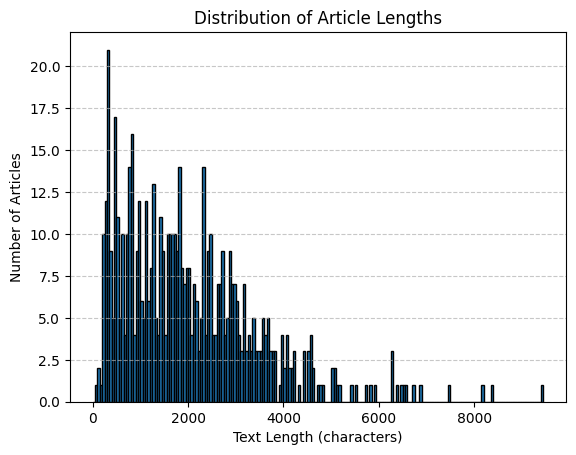

In [11]:
# Drop NaN values in 'filtered_text' column
df = df.dropna(subset=['filtered_text'])

# Calculate the length of each article in 'filtered_text'
df['text_length'] = df['filtered_text'].apply(len)

# Define bins for text lengths
bins = range(0, df['text_length'].max() + 50, 50)

# Create a histogram
plt.hist(df['text_length'], bins=bins, edgecolor='black')

# Customize the plot
plt.title('Distribution of Article Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Number of Articles')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [12]:
df.head()

,url,timestamp,processed_url_text,newspaper,arquivo_url,title,filtered_text,text_length,Lemmas_filtered,Lemmas_str,sentiment,sentiment_bin,sentiment_score,sentiment_label,published_date,year,entities,filtered_entities
0,https://www.cmjornal.pt/mundo/detalhe/andre-ve...,20210125190801,andre ventura apelidado de trump portugues na ...,cmjornal.pt/,https://arquivo.pt/noFrame/replay/202101251908...,"André Ventura apelidado de ""Trump português"" n...",Jornal francês destaca ascensão da extrema dir...,1928,"[jornal, francês, destacar, ascensão, extremo,...",jornal francês destacar ascensão extremo país ...,0.30,Slightly Positive,3.0,positive,2024-12-08 15:55:00,2021,"[('País', 'LOC'), ('Marcelo Rebelo de Sousa', ...","[('Le Parisien', 'PER'), ('André Ventura', 'PE..."
1,https://www.cmjornal.pt/politica/detalhe/debat...,20210120182636,debate tenso entre andre ventura e joao ferrei...,cmjornal.pt/,https://arquivo.pt/noFrame/replay/202101201826...,Debate tenso entre André Ventura e João Ferrei...,Os candidatos presidenciais João Ferreira e An...,3960,"[candidato, presidencial, joão, ferreira, prot...",candidato presidencial joão ferreira protagoni...,0.00,Neutral,1.0,positive,2021-01-20 00:00:00,2021,"[('João Ferreira', 'PER'), ('André Ventura', '...","[('João Ferreira', 'PER'), ('André Ventura', '..."
2,https://www.dn.pt/edicao-do-dia/01-jul-2021/ve...,20210701033951,ventura acusa familia coxi de inventar discrim...,dn.pt/,https://arquivo.pt/noFrame/replay/202107010339...,"Ventura acusa família Coxi de ""inventar discri...","Ventura acusa família Coxi de ""inventar discri...",394,"[acusar, família, coxi, inventar, discriminaçã...",acusar família coxi inventar discriminação aju...,0.00,Neutral,-3.0,negative,2021-07-01 00:00:00,2021,"[('Coxi', 'PER'), ('Chega', 'LOC'), ('Bairro d...","[('Coxi', 'PER')]"
3,https://www.dn.pt/edicao-do-dia/07-ago-2020/cr...,20200807084230,crianca negra cartaz em manifestacao do chega,dn.pt/,https://arquivo.pt/noFrame/replay/202008070842...,"Criança negra ""cartaz"" em manifestação do Chega","Criança negra ""cartaz"" em manifestação do Cheg...",346,"[criança, negro, cartaz, manifestação, menina,...",criança negro cartaz manifestação menina negro...,0.00,Neutral,-1.0,negative,2020-08-07 00:00:00,2020,"[('Chega\n\n', 'MISC'), ('Menina', 'PER'), ('C...","[('Menina', 'PER')]"
4,https://www.dn.pt/edicao-do-dia/08-out-2019/os...,20200207064445,os ciganos de alvito votaram no chega ha quem ...,dn.pt/,https://arquivo.pt/noFrame/replay/202002070644...,Os ciganos de Alvito votaram no Chega? Há quem...,Os ciganos de Alvito votaram no Chega? Há quem...,279,"[cigano, alvito, votar, digar, extrema-direita...",cigano alvito votar digar extrema-direita parl...,0.05,Slightly Positive,0.0,neutral,2020-02-07 00:00:00,2020,"[('Alvito', 'LOC'), ('Chega?', 'MISC'), ('Cheg...","[('André Ventura', 'PER')]"


In [13]:

# Ensure all entries in 'Lemmas_filtered' are lists, replacing invalid entries with an empty list
df['Lemmas_filtered'] = df['Lemmas_filtered'].apply(lambda x: x if isinstance(x, list) else [])

# Join the lists in 'Lemmas_filtered' into strings
df['Lemmas_str'] = df['Lemmas_filtered'].apply(lambda x: ' '.join(x))

# Words out of the topics
not_topics = ['andre', 'andré','ventura', 'chega', 'partido', 'lusa', 'presidente', 'haver', 'deputado', 'se', 'querer']
stop_words = list(stop_words)
stop_words.extend(not_topics) # Add the words to the stop words list
# Step 1: Vectorize the text
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=stop_words)  # Adjust min_df and max_df as needed
doc_term_matrix = vectorizer.fit_transform(df['Lemmas_str'])

# Step 2: Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Choose number of topics
lda.fit(doc_term_matrix)

# Step 3: Extract topics and keywords
words = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[-5:]]  # Top 10 words per topic
    topics.append(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

# Step 4: Display topics
topics_df = pd.DataFrame({"Topic": topics})
print("Identified Topics:")
# Display df using ace tools
tools.display_dataframe_to_user(name="Identified Topics", dataframe=topics_df)

# Optional: Visualize topic distribution for each document
topic_distribution = lda.transform(doc_term_matrix)



Identified Topics:
Identified Topics


Topic
Loading ITables v2.2.3 from the internet... (need help?)


#### The block of code below cannot run on JP's computer, and it's changed to markdown to avoid the error. GPU cannot be used for the modelling

In [ ]:
# ## DON'T RUN THIS CODE
# sentiment_pipeline = pipeline(
#     "sentiment-analysis",
#     model = "neuralmind/bert-base-portuguese-cased",
#     tokenizer = "neuralmind/bert-base-portuguese-cased",
#     truncation=True,  # Truncate sequences longer than the model's maximum
#     max_length=512,  # Limit the length of the input sequence
# )

# # Perform sentiment analysis
# df['sentiment'] = df.iloc[:5]['filtered_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# # Display results
# tools.display_dataframe_to_user(name="Portuguese News Article Sentiment Analysis", dataframe=df)

TF-IDF Matrix


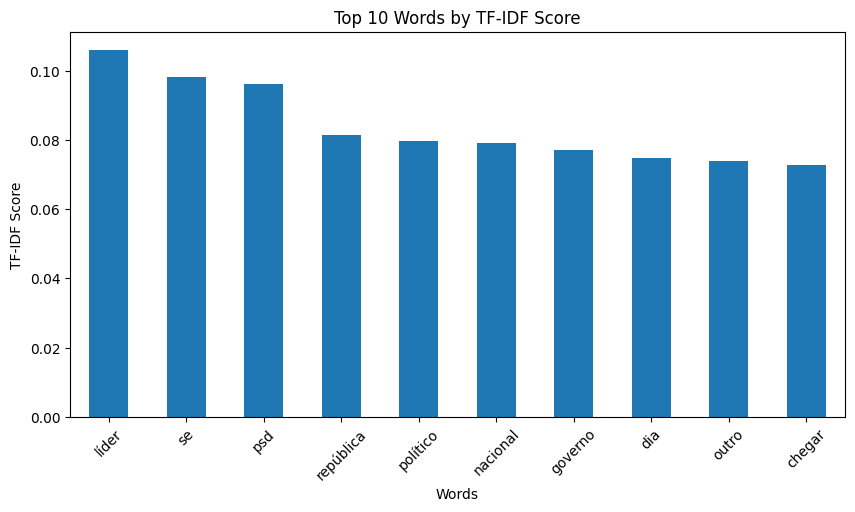

In [14]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, max_df=0.8, max_features=50)

# Compute TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['Lemmas_str'])

# Create a DataFrame to display the results
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Summarize TF-IDF scores
tfidf_mean = tfidf_df.mean(axis=0).sort_values(ascending=False)

tools.display_dataframe_to_user(name="TF-IDF Matrix", dataframe=tfidf_df)

# Plot the top 10 words by TF-IDF score
tfidf_mean.head(10).plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 Words by TF-IDF Score')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.show()

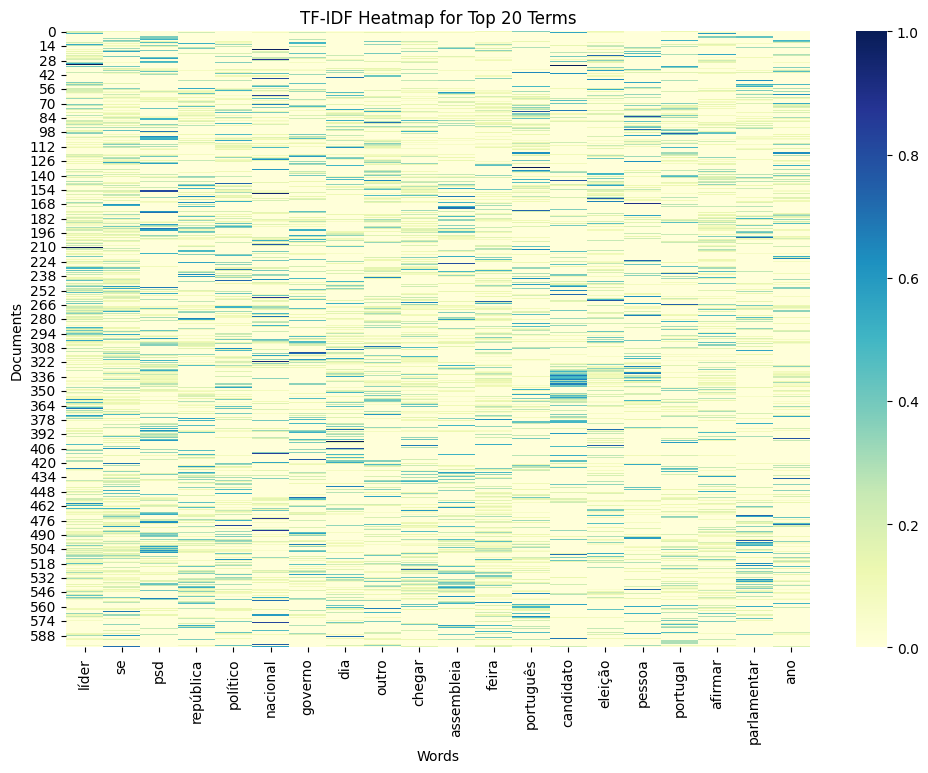

In [15]:
# Select the top 20 terms by mean TF-IDF score
top_terms = tfidf_mean.head(20).index
tfidf_top = tfidf_df[top_terms]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_top, annot=False, cmap='YlGnBu', cbar=True)
plt.title('TF-IDF Heatmap for Top 20 Terms')
plt.xlabel('Words')
plt.ylabel('Documents')
plt.show()

In [16]:
from textblob import TextBlob

df['sentiment'] = df['filtered_text'].apply(lambda x: TextBlob(x).sentiment.polarity)



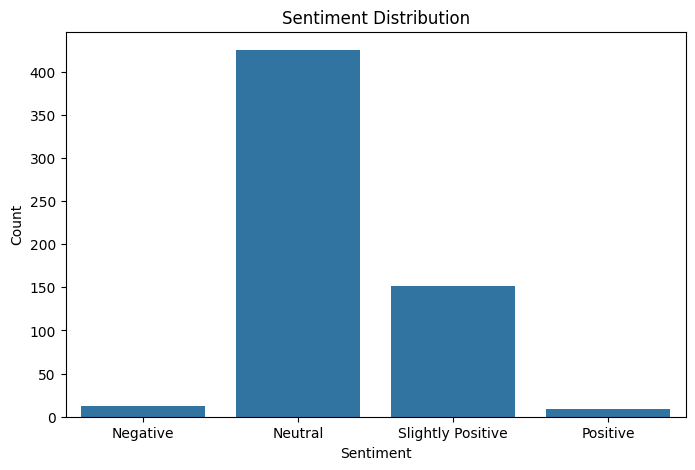

In [17]:
# Bin plotting of sentiment in df
bins = [-1, -0.5, 0, 0.5, 1]
labels = ['Negative', 'Neutral', 'Slightly Positive', 'Positive']
df['sentiment_bin'] = pd.cut(df['sentiment'], bins=bins, labels=labels)

# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_bin', data=df, order=labels)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [19]:
# Define file path
file_path = '/Users/joaop.cardoso/MestradoCD/FCD/FDS_Project/SentiLex-lem-PT02.txt'

# Load the TXT file and split into 5 columns
sentilex_df = pd.read_csv(file_path, sep=';', header=None, names=['col1', 'col2', 'col3', 'col4', 'col5'], engine='python')

# Extract structured fields using regex
sentilex_df['word'] = sentilex_df['col1'].str.extract(r'^(.*?)\.')  # Extract word before "."
sentilex_df['PoS'] = sentilex_df['col1'].str.extract(r'PoS=(\w+)')  # Extract part of speech
sentilex_df['TG'] = sentilex_df['col2'].str.extract(r'TG=(.*?)$')   # Extract TG field
sentilex_df['POL_N0'] = sentilex_df['col3'].str.extract(r'POL:N0=([-]?\d+)')  # Extract POL:N0
sentilex_df['POL_N1'] = sentilex_df['col3'].str.extract(r'POL:N1=([-]?\d+)')  # Extract POL:N1
sentilex_df['ANOT'] = sentilex_df['col4'].str.extract(r'ANOT=(.*?)$')  # Extract ANOT field

# Drop original columns and retain structured data
structured_df = sentilex_df[['word', 'PoS', 'TG', 'POL_N0', 'POL_N1', 'ANOT']]

# Ensure that polarity columns are numeric and handle missing values
structured_df['POL_N0'] = pd.to_numeric(structured_df['POL_N0'], errors='coerce')
structured_df['POL_N1'] = pd.to_numeric(structured_df['POL_N1'], errors='coerce')

# Create a dictionary for fast lookups based on 'word' and polarity
# Example: Use POL_N0 as the primary polarity
sentilex_dict = structured_df.set_index('word')['POL_N0'].dropna().to_dict()

/var/folders/kl/mfb9z6_d1290hf_1b38hg6zr0000gn/T/ipykernel_4841/899917329.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structured_df['POL_N0'] = pd.to_numeric(structured_df['POL_N0'], errors='coerce')
/var/folders/kl/mfb9z6_d1290hf_1b38hg6zr0000gn/T/ipykernel_4841/899917329.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structured_df['POL_N1'] = pd.to_numeric(structured_df['POL_N1'], errors='coerce')


In [21]:
def analyze_sentiment(text, lexicon):
    tokens = re.findall(r'\b\w+\b', text.lower())  # Tokenize and lowercase
    sentiment = sum(lexicon.get(word, 0) for word in tokens)  # Sum word polarities
    return sentiment

# Apply sentiment analysis
df['sentiment_score'] = df['filtered_text'].apply(lambda x: analyze_sentiment(x, sentilex_dict))

# Assign sentiment label based on score
df['sentiment_label'] = df['sentiment_score'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
)



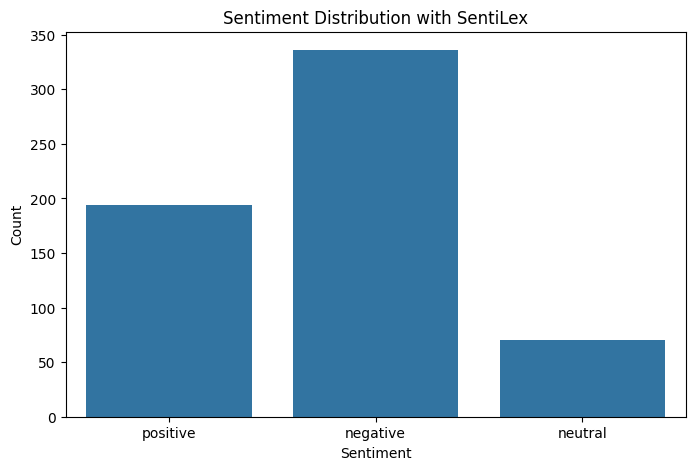

In [22]:
# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Distribution with SentiLex')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


#### Code to get the published date from meta data or span tag in html. 

It's important not to run this again. The dates that could not be retrieved (which were a lot of them9 were filled using the timestamp)

In [ ]:
## DON'T RUN THIS CODE
def extract_published_date(url):
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract published date from meta tags
        meta_date = soup.find('meta', {'property': 'article:published_time'}) or soup.find('meta', {'name': 'date'})
        if meta_date:
            return meta_date.get('content')
        
        # Extract visible date (if available)
        visible_date = soup.find('time') or soup.find('span', {'class': 'published-date'})
        if visible_date:
            return visible_date.text.strip()
        
        # Return a placeholder if no date is found
        return "Date Not Found"
    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        return "Error"
    
# Apply the function to the DataFrame
df['published_date'] = df['arquivo_url'].apply(extract_published_date)
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

In [69]:
# Export df to csv
df.to_csv('working_file_061224.csv', index=False)

In [23]:
# Load SpaCy's Portuguese model
nlp = spacy.load("pt_core_news_sm")

def extract_entities(text):
    """
    Extract named entities from the given text using SpaCy.
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply the function to the DataFrame
df['entities'] = df['filtered_text'].apply(extract_entities)

df['filtered_entities'] = df['entities'].apply(
    lambda entity_list: [(text, label) for text, label in entity_list if label in {"PER", "ORG"}]
)

Despite the code below, I went through the csv file and removed the sentences in the scraped text that contained a lot of text that wasn't relevant, and were distorting our model and the statistics (things like titles from linked articles in the article to be scraped, the author's name, photographer and news agency that covered the article).

In [ ]:
df['filtered_entities'] = df['filtered_entities'].apply( # Remove entities with 'foto' or 'lusa'
    lambda entities: [
        (text, label) for text, label in entities 
        if 'foto' not in text.lower() and 'lusa' not in text.lower()
    ]
)

def is_valid_person_name_spacy(name):
    """
    Use SpaCy to determine if a name follows common patterns for Portuguese names.
    """
    doc = nlp(name)
    # Check if all tokens are alphabetic and proper nouns
    return all(token.is_alpha and token.pos_ == "PROPN" for token in doc)

# Apply the function
df['filtered_entities'] = df['filtered_entities'].apply(
    lambda entities: [
        (text, label) for text, label in entities
        if label == "PER" and is_valid_person_name_spacy(text)
    ]
)


print(df['filtered_entities'])

0      [(Le Parisien, PER), (André Ventura, PER), (An...
1      [(João Ferreira, PER), (André Ventura, PER), (...
2                                          [(Coxi, PER)]
3                                        [(Menina, PER)]
4                                 [(André Ventura, PER)]
                             ...                        
595                                       [(Costa, PER)]
596                                       [(Costa, PER)]
597    [(Nuno Veiga, PER), (Nuno Veiga, PER), (André ...
598    [(Nuno Afonso, PER), (André Ventura, PER), (Ma...
599    [(Mithá Ribeiro, PER), (André Ventura, PER), (...
Name: filtered_entities, Length: 600, dtype: object


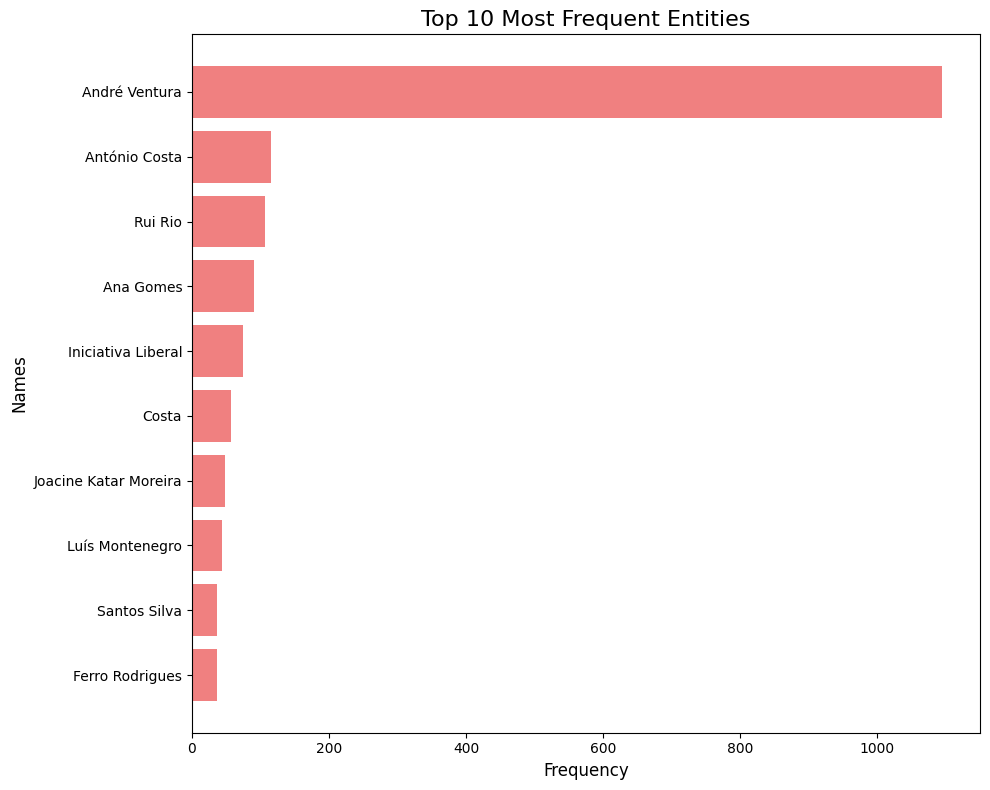

In [27]:
# Flatten the filtered_entities into a single list of names (discard labels for plotting)
all_names = [
    text for entities in df['filtered_entities'] for text, label in entities
]

# Count frequencies of each name
name_counts = Counter(all_names)


def plot_top_entities(entity_counts, top_n=10):
    """
    Plot only the top N entities by frequency.
    """
    # Get the top N entities
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    names, counts = zip(*sorted_entities)

    # Create horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(names, counts, color="lightcoral")
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Names", fontsize=12)
    plt.title(f"Top {top_n} Most Frequent Entities", fontsize=16)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

plot_top_entities(name_counts, top_n=10)

#### LDA (Latent Dirichlet Allocation) is a type of topic modelling
It is used to find the topics that are present in a corpus of text. It is a generative probabilistic model that assumes that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.

In [45]:
# Use Lemmas_filtered as is (already tokenized)
dictionary = Dictionary(df['Lemmas_filtered'])
dictionary.filter_extremes(no_below=10, no_above=0.5)  # Filter out infrequent and very frequent words

corpus = [dictionary.doc2bow(text) for text in df['Lemmas_filtered']]


In [ ]:
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10, random_state=42) # LDA model with 5 topics

# Print the top words for each topic
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(f"Topic {topic[0]}: {topic[1]}")

Topic 0: 0.026*"psd" + 0.016*"governo" + 0.010*"político" + 0.010*"ps" + 0.008*"costa" + 0.008*"rio" + 0.008*"afirmar" + 0.008*"chegar" + 0.007*"acordo" + 0.007*"açores"
Topic 1: 0.013*"voto" + 0.012*"eleição" + 0.010*"rodrigues" + 0.010*"república" + 0.008*"assembleia" + 0.008*"cds" + 0.008*"psd" + 0.008*"constitucional" + 0.008*"nacional" + 0.007*"ano"
Topic 2: 0.016*"parlamentar" + 0.011*"político" + 0.009*"assembleia" + 0.009*"república" + 0.009*"parlamento" + 0.009*"deputada" + 0.008*"joacine" + 0.008*"cigano" + 0.007*"declaração" + 0.007*"país"
Topic 3: 0.018*"nacional" + 0.013*"militante" + 0.010*"convenção" + 0.009*"congresso" + 0.009*"direção" + 0.008*"político" + 0.008*"dia" + 0.008*"chegar" + 0.007*"tribunal" + 0.006*"eleição"
Topic 4: 0.014*"república" + 0.012*"português" + 0.012*"marcelo" + 0.009*"candidato" + 0.009*"outro" + 0.009*"presidencial" + 0.008*"portugal" + 0.008*"rebelo" + 0.007*"sousa" + 0.007*"dia"


In [48]:
# Define the topic labels
topic_labels = {
    0: "Political Leadership and Party Governance [0]",
    1: "Elections and Constitutional Framework [1]",
    2: "Parliamentary Politics and Minority Representation [2]",
    3: "Party Conventions and Internal Dynamics [3]",
    4: "Presidential Elections and National Identity [4]",
}

# Function to assign labels based on the topic
def assign_topic_label(topic_id):
    return topic_labels.get(topic_id, "Unknown Topic")

# Get the dominant topic for each document and assign the label
document_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]
df['dominant_topic'] = document_topics
df['topic_label'] = df['dominant_topic'].apply(assign_topic_label)

topic_frequency = pd.DataFrame(document_topics, columns=["dominant_topic"])

topic_frequency["topic_label"] = topic_frequency["dominant_topic"].map(topic_labels)

# Compute the frequency of each topic

topic_frequency_count = topic_frequency["topic_label"].value_counts().reset_index()

topic_frequency_count.columns = ["Topic", "Frequency"]

tools.display_dataframe_to_user(name="Topic Frequency in Dataset", dataframe=topic_frequency_count)

Topic Frequency in Dataset


In [49]:
from gensim.models.coherencemodel import CoherenceModel

# Compute coherence score
coherence_model = CoherenceModel(model=lda_model, texts=df['Lemmas_filtered'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.4008711416263136


In [50]:
# Prepare the pyLDAvis visualization
pyLDAvis.enable_notebook()  # For Jupyter Notebook; omit for scripts
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_vis)

# Save the visualization as an HTML file
pyLDAvis.save_html(lda_vis, "lda_visualization.html")

/opt/anaconda3/envs/masters/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4841) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/envs/masters/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4841) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/envs/masters/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4841) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/envs/masters/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4841) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/envs/masters/lib/python3.12/site-packages/job

<Axes: xlabel='year'>

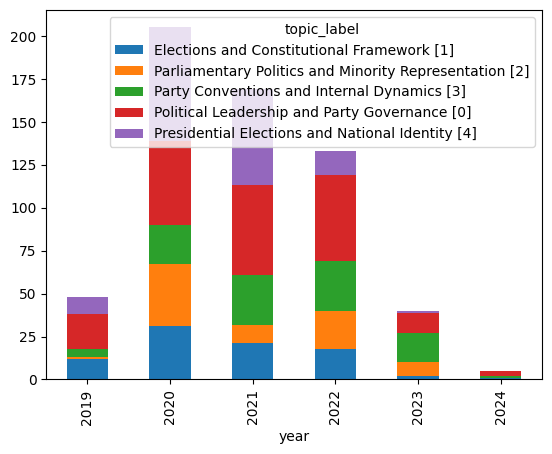

In [52]:
topic_trends = df.groupby(['year', 'topic_label']).size().unstack(fill_value=0)
topic_trends.plot(kind='bar', stacked=True)